In [ ]:
# !pip install matplotlib_venn python-rake summa keybert

In [60]:
import os
import RAKE
import nltk
from nltk.corpus import stopwords
from summa import keywords
from keybert import KeyBERT
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# 1.

Этот корпус состоит из текстов новостей по 10 категориям. Я взяла 6 текстов из категории "технологии". Ключевые слова перечислены в отдельном файле. Здесь именно слова, нет словосочетаний.

Источник: [500N-KPCrowd-v1.1](https://github.com/LIAAD/KeywordExtractor-Datasets/blob/master/datasets/500N-KPCrowd-v1.1.zip)

Статья: [Keyphrase cloud generation of broadcast news](https://arxiv.org/abs/1306.4606)

In [4]:
texts = {}
key_words = {}

for root, dirs, files in os.walk("corpus"):
    for name in files:
        filename, file_extension = os.path.splitext(name)
        with open(os.path.join(root, name), encoding="utf-8") as file:
            text = file.read()
        
        if file_extension == ".txt":
            texts[filename] = text
        else:
            key_words[filename] = text.split()

In [80]:
for key in key_words:
    key_words[key] = set([k.lower() for k in key_words[key]])

# 3.

Я использовала 3 метода:
* RAKE
* TextRank
* KeyBERT

In [38]:
results_rake = {}
results_textrank = {}
results_keybert = {}

### RAKE

In [9]:
stop = stopwords.words('english')

In [11]:
rake = RAKE.Rake(stop)

In [39]:
for key in texts:
    results_rake[key] = rake.run(texts[key], maxWords=1, minFrequency=2)

### TextRank

In [44]:
for key in texts:
    results_textrank[key] = keywords.keywords(texts[key], language='english', additional_stopwords=stop, scores=True)

### KeyBERT

In [24]:
kw_model = KeyBERT('clips/mfaq')

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Julia\anaconda3\lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [41]:
for key in texts:
    results_keybert[key] = kw_model.extract_keywords(texts[key], stop_words=stop, top_n=len(key_words["tech-20949702"]))

# 4.

Поскольку здесь в ключевых словах нет словосочетаний, то шаблоны только такие:
Noun, Adj, Verb, Adv

In [96]:
from nltk import pos_tag

In [102]:
tags = ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "RB", "RBR", "RBS", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]

results_rake_filtered = {}
results_textrank_filtered = {}
results_keybert_filtered = {}

In [103]:
for key in texts:
    for before, after in zip([results_rake, results_textrank, results_keybert], [results_rake_filtered, results_textrank_filtered, results_keybert_filtered]):
        after[key] = [word for word, pos in pos_tag([p[0] for p in before[key]]) if pos in tags]

# 5.

In [112]:
def count_metrics(true, pred, filtered=False):
    if not filtered:
        pred = [p[0] for p in pred]
    TP = 0
    FP = 0
    FN = sum([1 for word in true if word in pred])
    for word in pred:
        if word in true:
            TP += 1
        else:
            FP += 1 
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * precision * recall / (precision + recall)
    return precision, recall, f_score

In [114]:
columns = ["text", "method", "precision", "recall", "f_score", "filtered"]
results = []

for key in texts:
    for method, res in zip(["rake", "textrank", "keybert"], [results_rake, results_textrank, results_keybert]):
        if res[key]:
            p, r, f = count_metrics(key_words[key], res[key])
        else:
            p, r, f = (0, 0, 0)
        df = pd.DataFrame([[key, method, p, r, f, 0]], columns=columns)
        results.append(df)
        
for key in texts:
    for method, res in zip(["rake", "textrank", "keybert"], [results_rake_filtered, results_textrank_filtered, results_keybert_filtered]):
        if res[key]:
            p, r, f = count_metrics(key_words[key], res[key], True)
        else:
            p, r, f = (0, 0, 0)
        df = pd.DataFrame([[key, method, p, r, f, 1]], columns=columns)
        results.append(df) 

In [115]:
results_df = pd.concat(results)

Ниже результаты усредненные по текстам для каждого метода

In [116]:
results_df.groupby(["method", "filtered"]).mean()

precision    recall   f_score
method   filtered                               
keybert  0          0.318641  0.500000  0.371401
         1          0.326751  0.500000  0.377723
rake     0          0.307540  0.416667  0.338146
         1          0.308119  0.416667  0.339115
textrank 0          0.438386  0.500000  0.437942
         1          0.439745  0.500000  0.439363

In [117]:
results_df.groupby(["filtered"]).mean()

,precision,recall,f_score
filtered,,,
0,0.354856,0.472222,0.382496
1,0.358205,0.472222,0.385400


In [118]:
results_df.groupby(["method"]).mean()

,precision,recall,f_score,filtered
method,,,,
keybert,0.322696,0.500000,0.374562,0.5
rake,0.307830,0.416667,0.338630,0.5
textrank,0.439066,0.500000,0.438653,0.5


# 6.

Как видно, качесто совсем плохое. Лучше всего справился TextRank, хуже всего -- RAKE. С морфосинтаксическим фильтром стало немного лучше.

Для того, чтобы посмотреть, что лишнее выделяется или не выделяется, возьмем текст "tech-20949702" и метод textrank

In [84]:
pred = set([p[0] for p in results_textrank["tech-20949702"]])
true = key_words["tech-20949702"]

Предсказалось меньше ключевых слов

In [85]:
print(f"true: {len(true)}, pred: {len(pred)}")

true: 84, pred: 50


Я попыталась визуализировать ключевые слова на кругах Эйлера. Видно, что не предсказанных из нужных больше, чем лишних предсказанных. Предсказаны несколько словосочетаний, хотя здесь все ключевые слова состоят из одного слова. Например, среди ключевых слов есть app, tv, а среди предсказанных -- ipad app, tv channels, то есть они содержать нужные слова, но выделили еще лишние в добавок к ним.

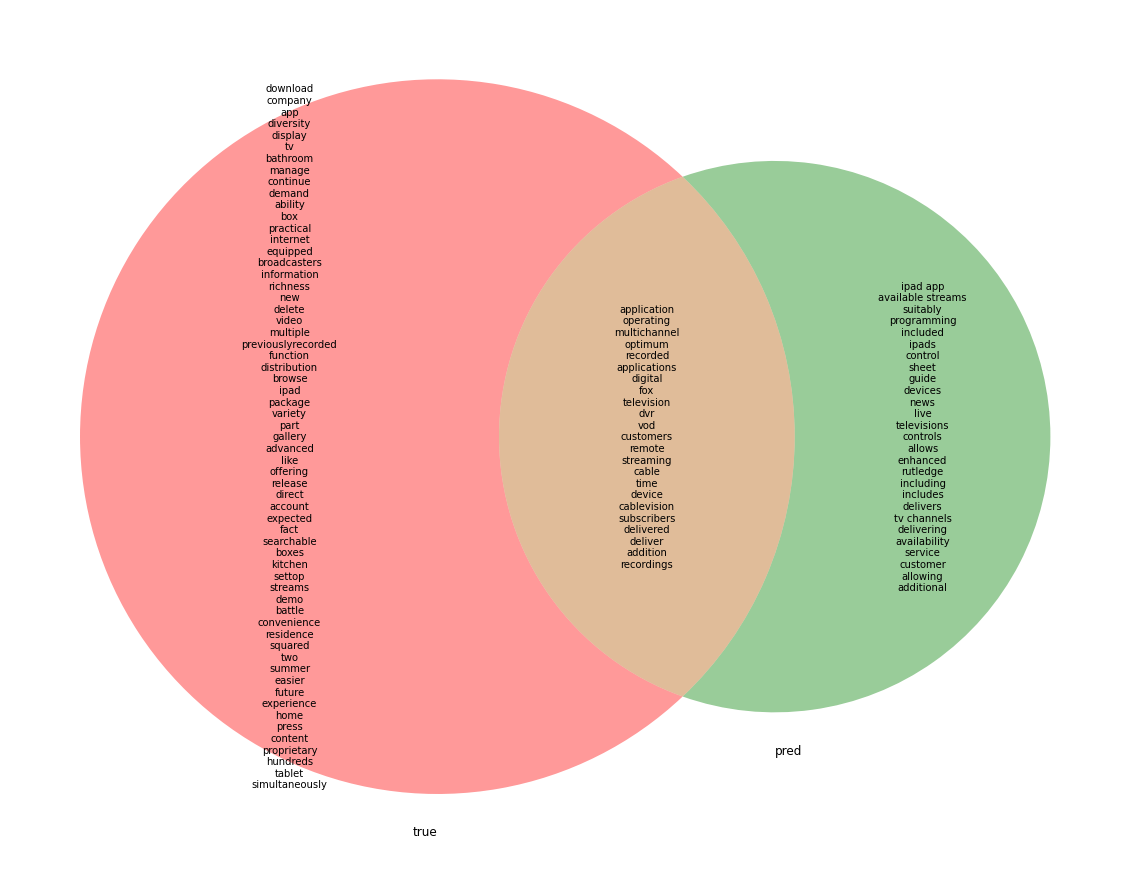

In [95]:
plt.figure(figsize=(20,20))
v = venn2([true, pred], set_labels=("true", "pred"))
v.get_label_by_id('10').set_text('\n'.join(true-pred))
v.get_label_by_id('11').set_text('\n'.join(true&pred))
v.get_label_by_id('01').set_text('\n'.join(pred-true))
plt.show()

На всякий случай еще перечислила просто списком для удобства. Сначала неверно предсказанные, а потом недо-предсказанные.

In [87]:
pred.difference(true)

{'additional',
 'allowing',
 'allows',
 'availability',
 'available streams',
 'control',
 'controls',
 'customer',
 'delivering',
 'delivers',
 'devices',
 'enhanced',
 'guide',
 'included',
 'includes',
 'including',
 'ipad app',
 'ipads',
 'live',
 'news',
 'programming',
 'rutledge',
 'service',
 'sheet',
 'suitably',
 'televisions',
 'tv channels'}

In [86]:
true.difference(pred)

{'ability',
 'account',
 'advanced',
 'app',
 'bathroom',
 'battle',
 'box',
 'boxes',
 'broadcasters',
 'browse',
 'company',
 'content',
 'continue',
 'convenience',
 'delete',
 'demand',
 'demo',
 'direct',
 'display',
 'distribution',
 'diversity',
 'download',
 'easier',
 'equipped',
 'expected',
 'experience',
 'fact',
 'function',
 'future',
 'gallery',
 'home',
 'hundreds',
 'information',
 'internet',
 'ipad',
 'kitchen',
 'like',
 'manage',
 'multiple',
 'new',
 'offering',
 'package',
 'part',
 'practical',
 'press',
 'previouslyrecorded',
 'proprietary',
 'release',
 'residence',
 'richness',
 'searchable',
 'settop',
 'simultaneously',
 'squared',
 'streams',
 'summer',
 'tablet',
 'tv',
 'two',
 'variety',
 'video'}